In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [11]:
sales_df = pd.read_csv('/Users/mohamedsabeer/Desktop/TS & NLP/sales_data.csv', parse_dates=['date'])
sales_df = sales_df.set_index('date')
sales_df.head()

,sales,promotion_flag,holiday_flag
date,,,
2023-01-01,415.000000,1,1
2023-01-02,407.118586,0,0
2023-01-03,268.092143,0,0
2023-01-04,283.778593,0,1
2023-01-05,334.041711,0,0


In [12]:
feedback_df = pd.read_csv('/Users/mohamedsabeer/Desktop/TS & NLP/customer_feedback.csv')
feedback_df.head()

,date,text,label
0,2023-01-01,Great product quality and fast delivery,positive
1,2023-01-02,Delivery was late and customer support was unh...,negative
2,2023-01-03,"Average experience, nothing special",neutral
3,2023-01-04,Excellent service and good packaging,positive
4,2023-01-05,Price is too high for the value offered,negative


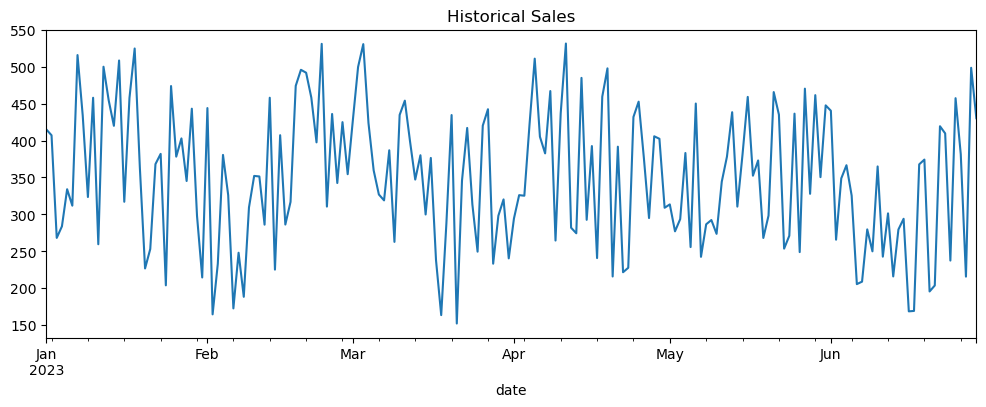

ADF Statistic: -5.327801666363581
p-value: 4.794398702102946e-06


In [13]:
sales_df['sales'].plot(figsize=(12,4), title='Historical Sales')
plt.show()

result = adfuller(sales_df['sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

In [14]:
exog = sales_df[['promotion_flag', 'holiday_flag']]

model = SARIMAX(
    sales_df['sales'],
    exog=exog,
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1036.315
Date:                           Sun, 08 Feb 2026   AIC                           2086.630
Time:                                   21:19:26   BIC                           2108.663
Sample:                               01-01-2023   HQIC                          2095.569
                                    - 06-29-2023                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
promotion_flag    -0.7172     15.517     -0.046      0.963     -31.130      29.695
holiday_flag      24.2981     2

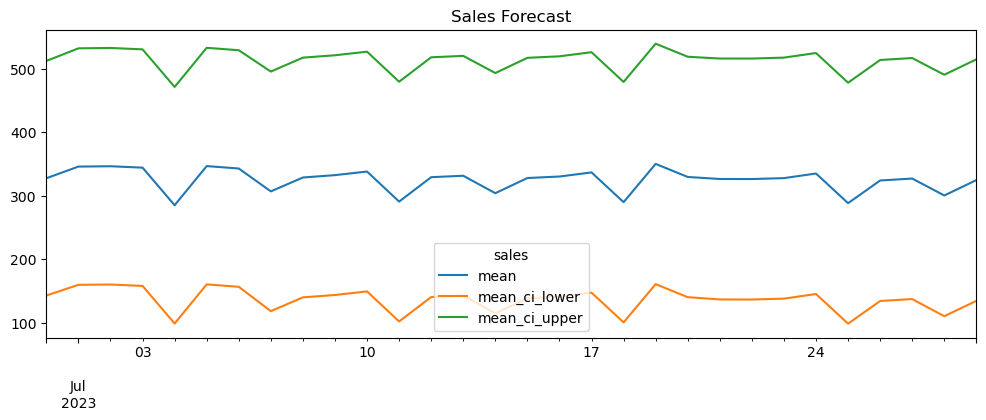

In [15]:
future_exog = exog.iloc[-30:]
forecast = results.get_forecast(steps=30, exog=future_exog)
forecast_df = forecast.summary_frame()
forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']].plot(figsize=(12,4))
plt.title('Sales Forecast')
plt.show()

In [16]:
X = feedback_df['text']
y = feedback_df['label']

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vec = vectorizer.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       1.0
    positive       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



In [18]:
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
feedback_df['sentiment_score'] = feedback_df['label'].map(sentiment_map)

sentiment_ts = feedback_df.groupby('date')['sentiment_score'].mean()
sentiment_ts.head()

date
2023-01-01    1.0
2023-01-02   -1.0
2023-01-03    0.0
2023-01-04    1.0
2023-01-05   -1.0
Name: sentiment_score, dtype: float64

In [19]:
latest_growth = forecast_df['mean'].pct_change().mean()
avg_sentiment = feedback_df['sentiment_score'].mean()

insight = f"""
Sales are expected to {'increase' if latest_growth > 0 else 'decline'} over the next period.

Key Drivers:
- Average customer sentiment: {avg_sentiment:.2f}
- Promotions and seasonal effects are influencing demand.

Recommendation:
Focus on improving areas with negative feedback while leveraging positive sentiment for marketing.
"""

print(insight)


Sales are expected to increase over the next period.

Key Drivers:
- Average customer sentiment: 0.00
- Promotions and seasonal effects are influencing demand.

Recommendation:
Focus on improving areas with negative feedback while leveraging positive sentiment for marketing.

